---
# **Ecuación del diodo de Shockley usando un ESP32 controlado por LabView**
---
Andrés Felipe Riaño Quintanilla     1083928808

Santiago Julio Dávila               1000413445

---
Laboratorio Avanzado I, Instituto de Física, Universidad de Antioquia

<img src="https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P1/p1-diagrama-1.png" alt="drawing" width="1200"/>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P1/p1.csv')
df

,Corriente_Diodo,Voltaje_Diodo
0,0.0,0.00
1,0.0,0.00
2,0.0,0.01
3,0.0,0.05
4,0.0,0.07
...,...,...
506,0.0,0.12
507,0.0,0.05
508,0.0,0.01
509,0.0,0.00


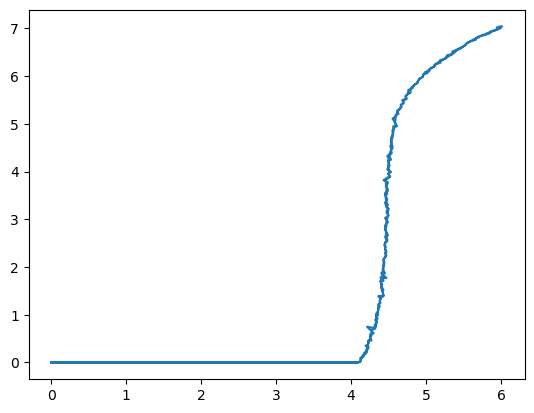

In [4]:
plt.plot(df['Voltaje_Diodo'],df['Corriente_Diodo'])